# Swarm	LP Ion Drift and Effective Mass	Products in VirES

This notebook demonstrates how Swarm LP Ion Drift and Effective Mass ([`EFIxIDM` products](https://earth.esa.int/eogateway/documents/20142/0/Swarm-LP-Ion-Drift-and-Effective-Mass-Product-Definition-SLIDEM)) data products can be visualised. The available variables and their mapping to source product variables are provided.

### Avaiable for Users Variables to change

Note that the source EFIxIDM_2_ products contain WGS84 geodetic coordinates rather than the ITRF geocentric sperical coordinates commonly used by other Swarm products. Although the differerences between the latitudes are not very large, VirES coverts the geodetic coordinates to the geocentric ones. The original coordinates from the source products are provided as a reference.

| VirES Variable | Description | 
|---|---|
|`SPACECRAFT`| Spacecraft options which user can change manually. Available 3 options "A", "B", "C" |
|`START_TIME/END_TIME`| Time for which to request data. This should be in ISO format (e.g. "2016-01-02T00:00:00Z") |
|`V_MAX`| Maximum value of Ion Effective Mass (passed directly at the end of notebook when calling function)

In [1]:
SPACECRAFT = "A" 
START_TIME = "2015-12-15T00:00:00Z"
END_TIME = "2016-01-30T00:00:00Z"
V_MAX = 25

### Requesting data from the server 

In [2]:
from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_duration, parse_datetime

SERVER_URL = "https://vires.services/ows"
COLLECTION = f"SW_PREL_EFI{SPACECRAFT}IDM_2_"

request = SwarmRequest(SERVER_URL)

start_orbit_number = request.get_orbit_number(SPACECRAFT, START_TIME, mission = 'Swarm')
end_orbit_number = request.get_orbit_number(SPACECRAFT, END_TIME)
start_time, end_time =  request.get_times_for_orbits(start_orbit_number, end_orbit_number, mission = 'Swarm', spacecraft=SPACECRAFT)
start_time, end_time = request.get_times_for_orbits(start_orbit_number, end_orbit_number, spacecraft=SPACECRAFT,  mission = 'Swarm')

In [3]:
def request_data(url, collection, start_time, end_time):
    """
    Make a request for data from the Swarm API.
    """
    request = SwarmRequest(url)
    request.set_collection(collection)
    request.set_products(
        measurements=["M_i_eff", "M_i_eff_Flags","M_i_eff_tbt_model"],        
        auxiliaries=['OrbitDirection', 'OrbitNumber', 'QDLat', 'QDOrbitDirection'],
        # sampling_step = "PT5S"
    )

    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=True,
    ).as_xarray()
    return data

data = request_data(SERVER_URL, COLLECTION, START_TIME, END_TIME)

          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (277.846MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (243.116MB)

In [4]:
import numpy as np

def get_orbit_latitude(latitude, orbit_direction):
    """ Unwrap latitude along the orbit.
    
    Returns:
        orbit_latitude ... unwrapped latitude values
    Args:
        latitude ... latitude values in degrees between -90 and 90.
        orbit_direction ... orbit direction flags
            +1 ascending direction
            -1 descnding direction
            0 means orbit direction is not available
    """
    orbit_latitude = np.array(latitude, copy=True)
    mask = (np.asarray(orbit_direction) == -1)
    orbit_latitude[mask] = 180 - orbit_latitude[mask] 
    orbit_latitude[orbit_latitude >= 180] -= 360 
    return orbit_latitude

### Time conversion functions and other utilities ...

Some special functions do not like to time data types and require the time to be converted to a number.

In [5]:
import numpy as np

EPOCH = np.datetime64("2000-01-01")


def times_to_seconds(times, epoch=None, precision="ns", scale=1e-9):
    """ Convert times (datetime64) to seconds (float).
    
    The epoch (zero value) is set by default to 2000-01-01T00:00:00.
    """
    if epoch is None:
        epoch = EPOCH
    return dtimes_to_seconds(np.asarray(times, "datetime64[ns]") - epoch, precision, scale)


def seconds_to_times(seconds, epoch=None, precision="ns", scale=1e9):
    """ Convert seconds (float) to times (datetime64).
    
    The epoch (zero value) is set by default to 2000-01-01T00:00:00.
    """
    if epoch is None:
        epoch = EPOCH
    return seconds_to_dtimes(seconds, precision, scale) + epoch


def dtimes_to_seconds(dtimes, precision="ns", scale=1e-9):
    """ Convert time differences (timedelta64) to seconds (float)
    with nanosecond precision.
    """
    return scale * np.asarray(dtimes, f"timedelta64[{precision}]").astype("int64")


def seconds_to_dtimes(seconds, precision="ns", scale=1e9):
    """ Convert seconds to time differences (timedelta64)
    with nanosecond precision.
    """
    return (scale * np.asarray(seconds)).astype("int64").astype(f"timedelta64[{precision}]")

### Data binning

In [6]:
from scipy.stats import binned_statistic_2d

def bin_data_2d(x, y, v, x_step, y_step, x_extent=None, y_extent=None, statistic='mean'):
    """ Conventience wrapper around the scipy.stats.binned_statistic_2d.
    
    See also https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html    
    
    Returns:
        result ... the calculated binned statictics (Ny x Nx array)
        x_edge ... edges of the bins in the x coordinate (Nx + 1 array)
        y_edge ... edges of the bins in the y coordinate (Ny + 1 array)
        
    Args:
        x ... 1st coordinate values
        y ... 2nd coordinate values
        v ... binned values
        x_step ... x proposed binning step (adjusted to fit the x_extent)
        y_step ... y proposed binning step (adjusted to fit the y_extent)
        x_extent ... optional pair of min. and max. boulds for the x coordinate
        y_extent ... optional pait of min. and max. boulds for the y coordinate
        staticstics ... type of the statistic to be calculated. For the possible
            options see the scipy.stats.binned_statistic_2d documentation.
    """
    def _get_bins(start, end, step):
        nstep = abs(int(np.ceil((end - start)/step))) + 1
        return np.linspace(start, end, nstep)
    
    if x_extent is None:
        x_extent = [x.min(), x.max()]

    if y_extent is None:
        y_extent = [y.min(), y.max()]

    result, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, v, statistic=statistic, bins=(
            _get_bins(x_extent[0], x_extent[1], x_step),
            _get_bins(y_extent[0], y_extent[1], y_step),
        ),
    )
    return result.T, x_edges, y_edges


def bin_time_data_2d(t, y, v, t_step, y_step, t_extent=None, y_extent=None, statistic='mean'):
    """ Conventience wrapper around the scipy.stats.binned_statistic_2d with time
    as the first coordinate.
    
    See also https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html    
    
    Returns:
        result ... the calculated binned statictics (Ny x Nt array)
        t_edge ... edges of the bins in the t coordinate (Nt + 1 array)
        y_edge ... edges of the bins in the y coordinate (Ny + 1 array)
        
    Args:
        t ... 1st coordinate values
        y ... 2nd coordinate values
        v ... binned values
        t_step ... x proposed binning step (adjusted to fit the t_extent)
        y_step ... y proposed binning step (adjusted to fit the y_extent)
        t_extent ... optional pair of min. and max. boulds for the t coordinate
        y_extent ... optional pait of min. and max. boulds for the y coordinate
        staticstics ... type of the statistic to be calculated. For the possible
            options see the scipy.stats.binned_statistic_2d documentation.
    """    
    if t_extent is None:
        t_extent = [t.min(), t.max()]
    
    result, t_edges, y_edges = bin_data_2d(
        times_to_seconds(t), y, v,
        x_step=dtimes_to_seconds(t_step),
        y_step=y_step,
        x_extent=times_to_seconds(t_extent),
        y_extent=y_extent,
        statistic=statistic,
    )
    return result, seconds_to_times(t_edges), y_edges

In [7]:
import numpy as np

mask = data['M_i_eff_Flags'].values & 0x01 == 0x00 # extract values for flag bit-0 set to 0
m_i_eff = data["M_i_eff"].values
m_tbt_model = data["M_i_eff_tbt_model"].values
timestamp = data["Timestamp"].values
orbit_number = data["OrbitNumber"].values
latitude = data["Latitude"].values
orbit_direction = data["OrbitDirection"].values
qd_latitude = data["QDLat"].values
qd_orbit_direction = data["QDOrbitDirection"].values


def _get_data_range(values):
    """ Get minimum and maximum values of an array. """
    values = values[~np.isnan(values)] # strip possible NaN values
    return values.min(), values.max()

### Checking M_i_eff values

M_i_eff value range: -1292.9 1482.0 a.m.u.


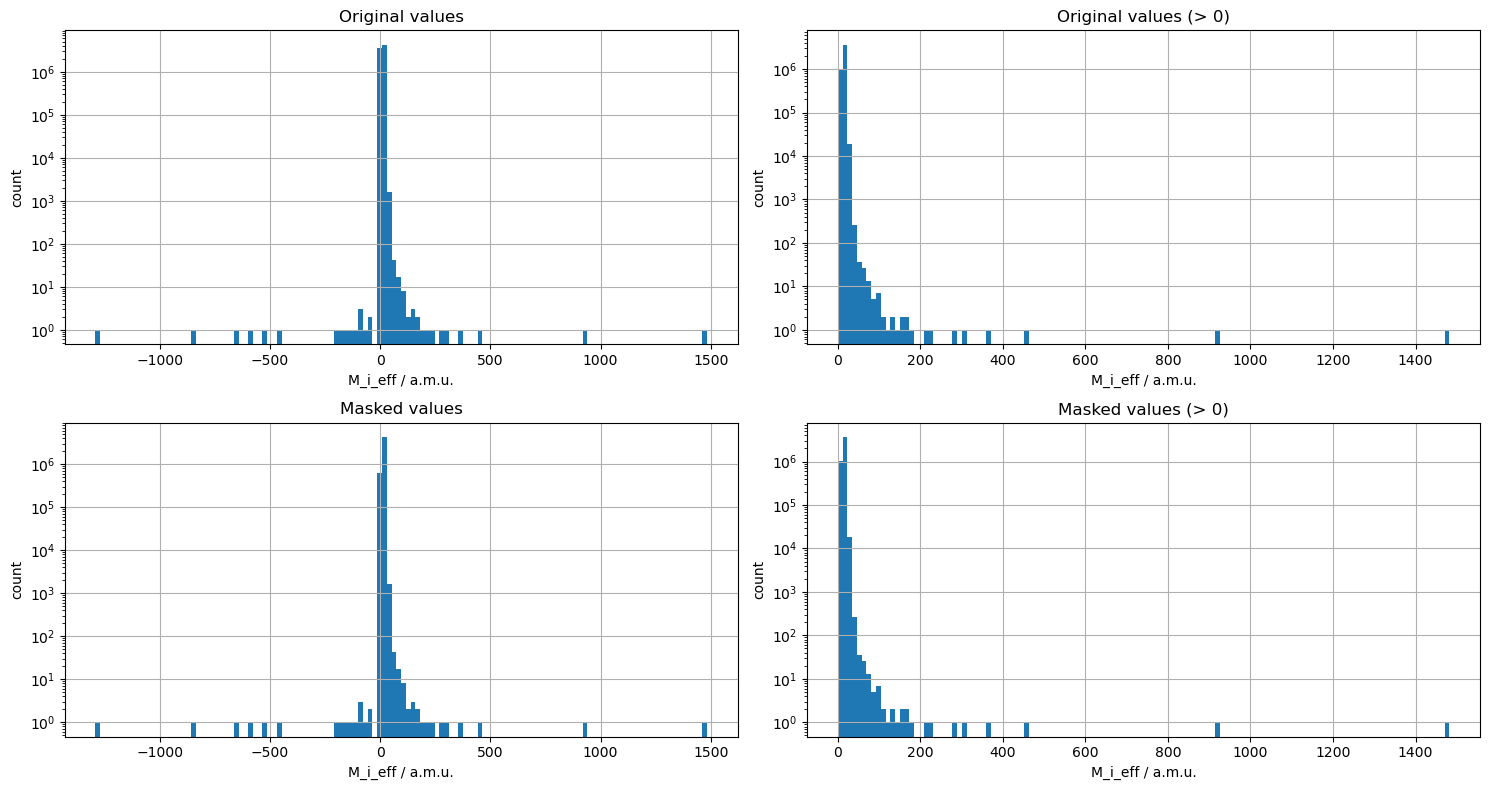

In [8]:
import matplotlib.pyplot as plt

v_min, v_max =_get_data_range(m_i_eff[mask])
print(f"M_i_eff value range: {v_min:.1f} {v_max:.1f} a.m.u.")


def plot_histogram(ax, value, title):
    ax.hist(value, bins=128)
    ax.set_yscale("log")
    ax.set_title(title)
    ax.set_ylabel("count")
    ax.set_xlabel("M_i_eff / a.m.u.")
    ax.grid()

    
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8), dpi=100)

plot_histogram(axs[0, 0], data["M_i_eff"].values, "Original values")
plot_histogram(axs[0, 1], data["M_i_eff"].values[data["M_i_eff"].values >= 0], "Original values (> 0)")
plot_histogram(axs[1, 0], data["M_i_eff"].values[mask], "Masked values")
plot_histogram(axs[1, 1], data["M_i_eff"].values[mask][data["M_i_eff"].values[mask] >= 0], "Masked values (> 0)")

plt.tight_layout()

Visualisation of Effective Ion Mass ('M_i_eff') values range using different types of masking

### Creating a plot

Plotting of median values for a given dataset (specified by maximum value of Ion Effective Mass, color_data, mask and label) as a function of orbit number and latitude. The plot is divided into bins based on these two parameters and the median value of each bin is represented by a color on the plot.

In [9]:
from matplotlib.colors import ListedColormap

orbit_latitude = get_orbit_latitude(qd_latitude, qd_orbit_direction) % 360

def plot_by_orbit(ax,v_max,orbit_number,orbit_latitude,color_data, mask, label):
    v_min=0
    # v_max = v_max

    values_bin_median, orbit_number_bin, orbit_latitude_bin = bin_data_2d(
        x=orbit_number[mask],
        y=orbit_latitude[mask],
        v=color_data[mask],
        x_step=2, # orbits per bin
        y_step=1, # 1 degree y-bins
        x_extent=[ 
            orbit_number.min(),
            orbit_number.max() + 1,
        ],
        y_extent=[0, 360],
        statistic='median',
    )

    values_bin_count, _, _ = bin_data_2d(
        x=orbit_number,
        y=orbit_latitude,
        v=np.ones(timestamp.shape),
        x_step=2, # orbits per bin
        y_step=1, # 1 degree y-bins
        x_extent=[ 
            orbit_number.min(),
            orbit_number.max() + 1,
        ],
        y_extent=[0, 360],
        statistic='count',
    )


    # remap orbits to times 
    time_bin = seconds_to_times(np.linspace(
        times_to_seconds(timestamp.min()),
        times_to_seconds(timestamp.max()),
        orbit_number_bin.size,
    ))

    # -----------------------------------------------------------------------------

    intensity = 0.85
    data_occurance_cmap = ListedColormap(np.asarray([
        (0.0, 0.0, 0.0, 0.0),
        (intensity, intensity, intensity, 1.0),
    ]))



    # plot rejected data with a light gray color
    ax.pcolormesh(
        time_bin,
        orbit_latitude_bin,
        values_bin_count > 0,
        cmap=data_occurance_cmap,
    )

    # plot the actual values
    im = ax.pcolormesh(
        time_bin,
        orbit_latitude_bin,
        values_bin_median,
        cmap='viridis_r',
        vmin=v_min,
        vmax=v_max
    )

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Latitude')
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label(f'{label} / a.m.u.')
    ax.set_ylim(0, 360)
    ax.set_yticks(
        [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360],
        ["0°↑", "+30°↑", "+60°↑", "+90°", "+60°↓", "+30°↓", "0°↓", "−30°↓", "−60°↓", "−90°", "−60°↑", "−30°↑", "0°↑"]
    )
    ax.grid()

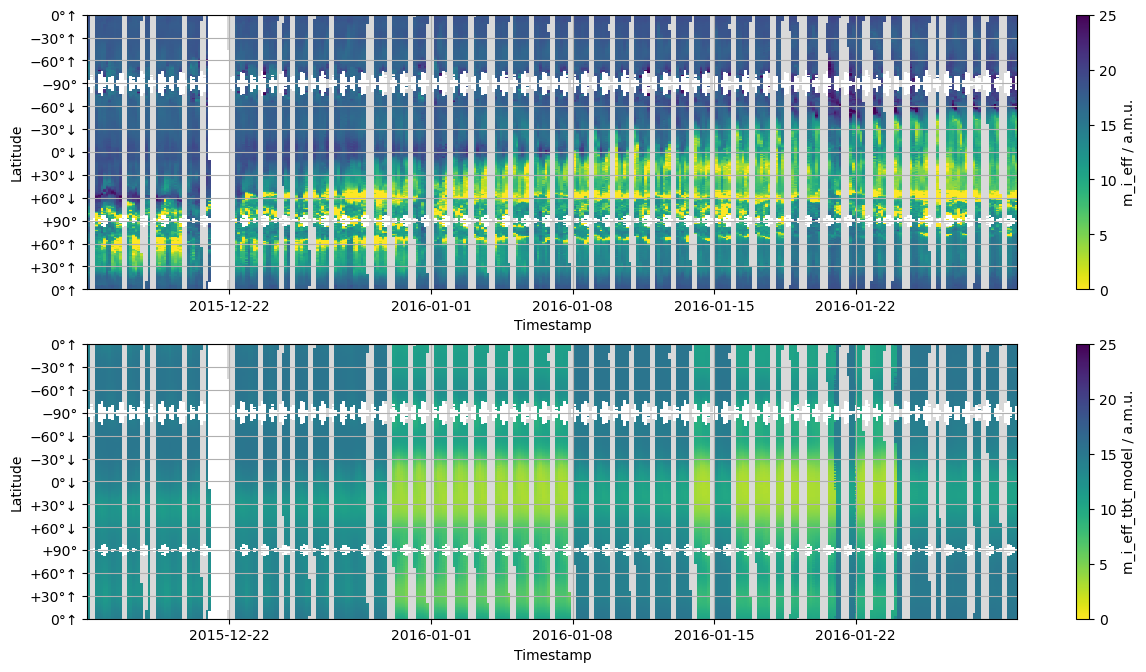

In [10]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=100, nrows=2, ncols=1)

plot_by_orbit(ax[0],V_MAX,orbit_number,orbit_latitude, m_i_eff,mask, "m_i_eff")
plot_by_orbit(ax[1],V_MAX ,orbit_number, orbit_latitude, m_tbt_model, m_tbt_model>0,"m_i_eff_tbt_model" )

Plot visualizes binned ion effective mass as a function of orbit number and latitude. The first subplot shows the median effective ion mass ('M_i_eff') while second subplot shows the median effective mass model based on Truhlik et al.(2015) empirical topside ion composition model. The plot is limited to a maximum ion mass value which is can be changed bhy user.